<a href="https://colab.research.google.com/github/benjuarez8/CS81C-Research-Bolivia/blob/main/cs81c_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
pip install Unidecode

     |████████████████████████████████| 235 kB 21.5 MB/s 


In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import csv
from sklearn.linear_model import LogisticRegression
from unidecode import unidecode
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

#Load Data

In [3]:
training_data = pd.read_csv("https://raw.githubusercontent.com/benjuarez8/Bolivia-SURF-2020/master/CS81C/training_data.csv")
training_data.rename( columns={"Unnamed: 0":"ID"}, inplace=True )
training_data.head()

,ID,Department,Turnout,MAS.vote,Fraud.type
0,1,Chuquisaca,0.859405,0.486528,Clean
1,2,Chuquisaca,0.894904,0.403457,Clean
2,3,Chuquisaca,0.897040,0.359153,Clean
3,4,Chuquisaca,0.904918,0.848769,VS
4,5,Chuquisaca,0.878844,0.428678,Clean


In [4]:
testing_data = pd.read_csv("https://raw.githubusercontent.com/benjuarez8/Bolivia-SURF-2020/master/CS81C/testing_data.csv")
testing_data.rename( columns={"Unnamed: 0":"ID"}, inplace=True )
testing_data.head()

,ID,Department,Municipality,Precinct,Turnout,MAS.vote
0,1,Chuquisaca,Sucre,Escuela Seccional De Chaunaca,0.863,0.789
1,2,Chuquisaca,Sucre,Unidad Educativa Chuqui Chuqui,0.869,0.702
2,3,Chuquisaca,Sucre,Unidad Educativa Chuqui Chuqui,0.892,0.686
3,4,Chuquisaca,Sucre,Escuela Fray Gabriel Maria Landini,0.822,0.778
4,5,Chuquisaca,Sucre,Escuela Fray Gabriel Maria Landini,0.847,0.729


#Data Processing

In [5]:
training_data["Fraud_num"] = [ -1 if type == "VS" else 1 if type == "BBS" else 0 for type in training_data["Fraud.type"] ]

In [6]:
training_departments = training_data["Department"].str.get_dummies()
training_data = pd.concat([training_data, training_departments], axis=1)
testing_departments = testing_data["Department"].str.get_dummies()
testing_data = pd.concat([testing_data, testing_departments], axis=1)
testing_data.rename( columns={"Potosí":unidecode("Potosí")}, inplace=True)

In [7]:
train_labels = training_data["Fraud_num"]
train = training_data[["Beni", "Chuquisaca", "Cochabamba", "La Paz", "Oruro", "Pando", "Potosi", "Santa Cruz", "Tarija", "Turnout", "MAS.vote"]]
test = testing_data[["Beni", "Chuquisaca", "Cochabamba", "La Paz", "Oruro", "Pando", "Potosi", "Santa Cruz", "Tarija", "Turnout", "MAS.vote"]]

In [8]:
X_train = np.array(train)
y_train = np.array(train_labels)
X_test = np.array(test)

#Logistic Regression

In [9]:
seed = 8
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
print(model)

LogisticRegression(max_iter=1000)


In [10]:
y_pred = model.predict(X_test)

In [11]:
pd.options.mode.chained_assignment = None
test["Pred_Fraud_num"] = y_pred.tolist()
test["Pred_Fraud_type"] = [ "VS" if type == -1 else "BBS" if type == 1 else "Clean" for type in test["Pred_Fraud_num"] ]
test["Department"] = testing_data["Department"]
test["Precinct"] = testing_data["Precinct"]
test["Municipality"] = testing_data["Municipality"]

In [12]:
test.to_csv("log_results.csv", index=False)

#Results

In [13]:
col_names = ["Clean", "At_Risk", "BBS_Risk", "VS_Risk", "Avg_Turnout", "Avg_MAS_vote"]
results = pd.DataFrame(columns = col_names)
counts = test.Pred_Fraud_type.value_counts()
clean = counts[0] / (counts[0] + counts[1] + counts[2])
tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
bbs = counts[1] / (counts[0] + counts[1] + counts[2])
vs = counts[2] / (counts[0] + counts[1] + counts[2])
avg_turnout = test["Turnout"].mean()
avg_vote = test["MAS.vote"].mean()
results.loc[len(results)] = [round(100*clean,2), round(100*tot_risk,2), round(100*bbs,2), round(100*vs,2), round(100*avg_turnout,2), round(avg_vote,2)]

In [14]:
results.to_csv("log_tot_results.csv", index=False)
results

,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,86.73,13.27,7.53,5.74,89.8,0.46


In [15]:
col_names = ["Department", "Clean", "At_Risk", "BBS_Risk", "VS_Risk", "Avg_Turnout", "Avg_MAS_vote"]
log_dep_results = pd.DataFrame(columns = col_names)
for dep in test["Department"].unique():
    vars()[dep] = test[test["Department"] == dep].Pred_Fraud_type.value_counts()
    counts = test[test["Department"] == dep].Pred_Fraud_type.value_counts()
    clean = counts[0] / (counts[0] + counts[1] + counts[2])
    tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
    bbs = counts[1] / (counts[0] + counts[1] + counts[2])
    vs = counts[2] / (counts[0] + counts[1] + counts[2])
    avg_turnout = test[test["Department"] == dep]["Turnout"].mean()
    avg_vote = test[test["Department"] == dep]["MAS.vote"].mean()
    log_dep_results.loc[len(log_dep_results)] = [dep, round(100*clean,2), round(100*tot_risk,2), round(100*bbs,2), round(100*vs,2), round(100*avg_turnout,2), round(avg_vote,2)]
log_dep_results = log_dep_results.sort_values(by = "Clean")
log_dep_results.reset_index(drop=True, inplace=True)

In [16]:
log_dep_results.to_csv("log_dep_results.csv", index=False)
log_dep_results

,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,Cochabamba,78.55,21.45,15.47,5.99,90.28,0.57
1,Potosí,86.61,13.39,6.91,6.48,88.87,0.46
2,La Paz,87.38,12.62,9.89,2.74,91.75,0.53
3,Santa Cruz,88.29,11.71,8.52,3.19,88.83,0.34
4,Oruro,89.92,10.08,7.43,2.65,91.09,0.47
5,Beni,91.33,8.67,5.50,3.17,86.17,0.34
6,Chuquisaca,91.84,8.16,5.76,2.40,88.41,0.40
7,Tarija,93.37,6.63,3.71,2.92,87.26,0.39
8,Pando,93.89,6.11,4.20,1.91,84.31,0.43


In [17]:
col_names = ["Municipality", "Department", "Clean", "At_Risk", "BBS_Risk", "VS_Risk", "Avg_Turnout", "Avg_MAS_vote"]
log_municip_results = pd.DataFrame(columns = col_names)
for municip in test["Municipality"].unique():
  dep = test.loc[test["Municipality"] == municip]["Department"].iloc[0]
  counts = test[test["Municipality"] == municip].Pred_Fraud_type.value_counts()
  if (len(counts) > 2):
    clean = counts[0] / (counts[0] + counts[1] + counts[2])
    tot_risk = (counts[1] + counts[2]) / (counts[0] + counts[1] + counts[2])
    bbs = counts[1] / (counts[0] + counts[1] + counts[2])
    vs = counts[2] / (counts[0] + counts[1] + counts[2])
    avg_turnout = test[test["Municipality"] == municip]["Turnout"].mean()
    avg_vote = test[test["Municipality"] == municip]["MAS.vote"].mean()
    log_municip_results.loc[len(log_municip_results)] = [municip, dep, round(100*clean,2), round(100*tot_risk,2), round(100*bbs,2), round(100*vs,2), round(100*avg_turnout,2), round(avg_vote,2)]
log_municip_results = log_municip_results.sort_values(by = "Clean")
log_municip_results.reset_index(drop=True, inplace=True)

In [18]:
log_municip_results.to_csv("log_municip_results.csv", index=False)
log_municip_results

,Municipality,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,Chacarilla,La Paz,33.33,66.67,33.33,33.33,90.33,0.81
1,Chayanta,Potosí,43.33,56.67,40.00,16.67,91.88,0.76
2,Sacaca,Potosí,45.45,54.55,30.30,24.24,93.73,0.85
3,Papel Pampa,La Paz,45.45,54.55,36.36,18.18,90.87,0.82
4,Caripuyo,Potosí,46.15,53.85,30.77,23.08,90.48,0.84
...,...,...,...,...,...,...,...,...
123,Nuestra Señora de La Paz,La Paz,95.75,4.25,4.04,0.21,91.00,0.40
124,San Lorenzo,Tarija,95.83,4.17,2.78,1.39,87.64,0.44
125,Bermejo,Tarija,95.97,4.03,2.42,1.61,84.90,0.45
126,Mineros,Santa Cruz,96.88,3.12,1.56,1.56,88.24,0.38


#Cross-Validation Accuracy

Replitting the training data into training/testing data for further analysis.  This is necessary to perform certain measurements because we do not have any "true" labels for the real election (test) data.

In [19]:
seed = 8
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, 
                                                    test_size = 0.5, 
                                                    shuffle = True,
                                                    random_state = seed)

Computes accuracy classification score for each of the ensemble classifiers.

In [20]:
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
model_acc = cross_val_score(model, X_train, y_train, 
                                scoring="accuracy", cv=cv, n_jobs=1)

In [21]:
print('Random Forest Accuracy: %.5f %%' % (100*np.mean(model_acc)))

Random Forest Accuracy: 96.67962 %


#AUC-ROC Curves

In [22]:
n_classes = 3
seed = 8
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, 
                                                    test_size = 0.5, 
                                                    shuffle = True,
                                                    random_state = seed)

Computing probabilities for outcomes of VS, Clean, BBS (stored in y_score).

In [23]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)

Binarizing the test labels (-1 -> [1,0,0], 0-> [0,1,0], 1-> [0,0,1]).

In [24]:
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])

Computing ROC curve and ROC area for each fraud risk label.

In [25]:
n_classes = 3 # classes = (VS, Clean, BBS)
fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

Plotting ROC curve for each label.  These results line up with patterns seen in SURF 2020 (such that BBS was more easily classified relative to other labels).  Take note of x and y limits of the plot.  It was necessary to "shrink" the dimensions in this way in order to visualize the curves.

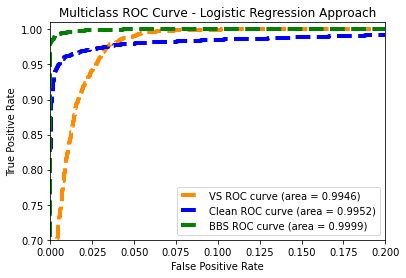

In [26]:
plt.figure()
lw = 4
plt.plot(fpr[0], tpr[0], color="darkorange", lw=lw, linestyle="--", 
         label="VS ROC curve (area = %0.4f)" % roc_auc[0])
plt.plot(fpr[1], tpr[1], color="blue", lw=lw, linestyle="--", 
         label="Clean ROC curve (area = %0.4f)" % roc_auc[1])
plt.plot(fpr[2], tpr[2], color="green", lw=lw, linestyle="--", 
         label="BBS ROC curve (area = %0.4f)" % roc_auc[2])

#plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 0.2])
plt.ylim([0.7, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve - Logistic Regression Approach")
plt.legend(loc="lower right")
plt.show()

#Confusion Matrix

Function to better visualize confustion matrix from confusion_matrix function from sklearn.  Adopted from the following source:

https://www.w3cschool.cn/doc_scikit_learn/scikit_learn-auto_examples-model_selection-plot_confusion_matrix.html

In [27]:
classes = ["VS", "Clean", "BBS"]
def plot_confusion_matrix(y_pred, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  cm = confusion_matrix(y_test, y_pred)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [28]:
y_pred = model.predict(X_test)

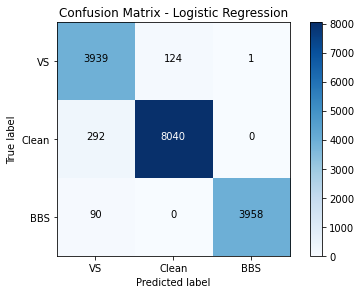

In [29]:
plt.figure()
plot_confusion_matrix(y_pred, classes=classes, title="Confusion Matrix - Logistic Regression")
plt.show()